# APS360 Final Project: Covid Mask Detector

### Names: Edwin Zhang, Lance Canlas, Stefano Katsoras, Marie Joy Cuevas

This file contains everything related to training our neural network(s).

## Global Imports

In [1]:
#Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os
import random


In [2]:
#Seed constant
SEED_CONST = 2020
#Set seeds to ensure repeatable training
def seed_torch(seed=SEED_CONST):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print("Set all seeds to {}".format(seed))

#initializes worker function for dataloaders
def _init_fn(worker_id):
    np.random.seed(SEED_CONST + worker_id)


## Loading Our Data

Split the data set into 60% train, 20% valdation, 20% test. Image pre-processing code is in image-preprocessing.ipynb file


In [3]:
#Master dataset
master = torchvision.datasets.ImageFolder('data_color_shifted', transform = transforms.ToTensor())

#split indexes
train_size = int(0.6 * len(master))
val_size = int(0.2 *len(master))
test_size = len(master) - val_size - train_size

train_set, val_set, test_set = torch.utils.data.random_split(master, [train_size, val_size, test_size])
print ("Length of training set: {}".format(len(train_set)))
print ("Length of val set: {}".format(len(val_set)))
print ("Length of test set: {}".format(len(test_set)))

Length of training set: 3485
Length of val set: 1161
Length of test set: 1163


In [4]:
def display_data (data_loader):
    '''
    Displays a few images to see if our data loaded properly
    
    data_loader: torch data_loader
    data_type: a string to show which data is displayed
    '''

    classes = ['Incorrect Mask', 'Mask', 'No Mask'] #CHANGED

    data = iter(data_loader)
    image, label = data.next()
    npImages = image.numpy() 
    
    # plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(npImages[i], (1, 2, 0)))
        ax.set_title(classes[label[i]])

#### Check Our Training Data

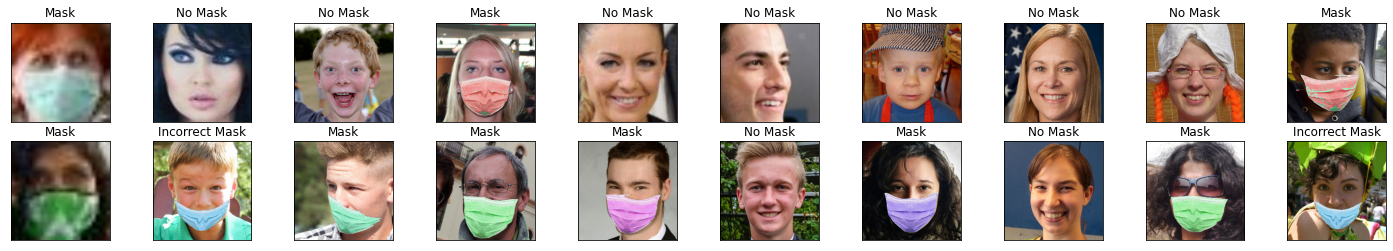

In [5]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1, shuffle=True)
display_data(train_data)

#### Check Our Validation Data

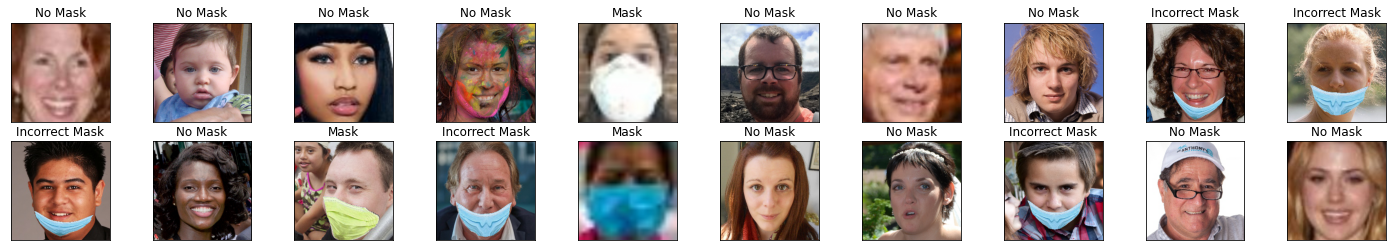

In [6]:
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1, shuffle=True)
display_data(val_data)

#### Check Our Test Data

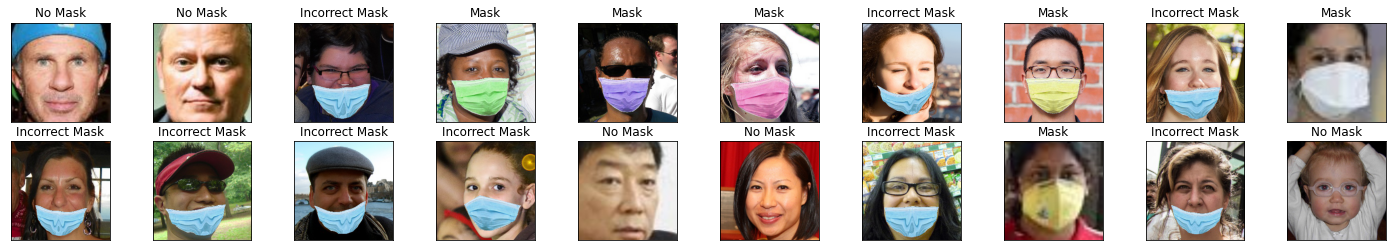

In [7]:
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1, shuffle=True)
display_data(test_data)

## Neural Networks
All of our networks are Convolutional Neural Networks due to their advantages while working with image classification problems.
All CNNs receive at RGB 240x240 input has a final output layer of 3 neurons for mask, no mask and incorrect mask.

Note: CNN versions do not indicate their success. For example version 2 may not necessarily be better than version 1

## Basic CNN Model - Version 1
This is the basic CNN version model, that has similar parameters to the CNN known as LeNet-5 (with 2 convolutional and pooling layers, followed by a flattening convolutional layer, then two linear layers). The SGD optimizer was used for our primary model because it is commonly used in CNNs and updates parameters based on each training sample.

In [8]:
class Basic_CNN(nn.Module):
    # 7 layers: 2 conv, 2 max pool, 2 linear, 1 output
    def __init__(self):
        self.name = "Basic_CNN"
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
        self.fc1 = nn.Linear(10*57*57, 32)
        self.fc2 = nn.Linear(32, 3) #CHANGED
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight.data)
            nn.init.xavier_uniform(m.bias.data)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img))) #relu activation function
        x = self.pool(F.relu(self.conv2(x))) #relu activation function
        x = x.view(-1, 10*57*57)
        x = F.relu(self.fc1(x)) #relu activation function
        x = self.fc2(x)
        return x

## Training Helper Functions

In [9]:
def get_accuracy(model, data_loader):
    '''
    Gets Correct/total
    
    Model: The CNN Model
    
    data_loader: torch dataloader
    '''
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    #Load data
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print("Done loading data")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    print ("Starting to train...")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        print("Epoch #: {0} Accuracy: {1}".format(epoch, train_acc[epoch]))
        
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    
    best_epoch = np.argmax(val_acc)
    model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, best_epoch)
    torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.6103299856527977
Epoch #: 1 Accuracy: 0.7480631276901004
Epoch #: 2 Accuracy: 0.8126255380200861
Epoch #: 3 Accuracy: 0.8407460545193687
Epoch #: 4 Accuracy: 0.8682926829268293
Epoch #: 5 Accuracy: 0.8820659971305596
Epoch #: 6 Accuracy: 0.8935437589670014
Epoch #: 7 Accuracy: 0.8981348637015782
Epoch #: 8 Accuracy: 0.9087517934002869
Epoch #: 9 Accuracy: 0.9162123385939742


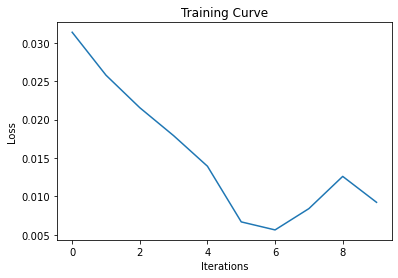

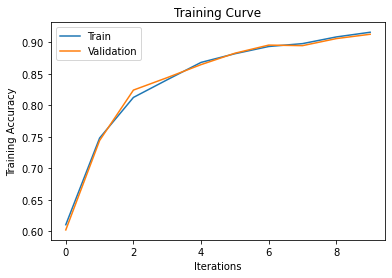

Final Training Accuracy: 0.9162123385939742
Final Validation Accuracy: 0.9130060292850991


In [12]:
use_cuda = True
torch.manual_seed(2020)
model = Basic_CNN()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 10)

In [14]:
#Test
best_model = Basic_CNN()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("Basic_CNN", 32, 0.00012, 8)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("test accuracy:", test_accuracy)

test accuracy: 0.8968185726569218


## CNN Model - Version 2

In [22]:
# Create a neural net class
class CNN_V2(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V2, self).__init__()
        self.name = "CNN_V2"
        
        # Our images are RGB, so we have input channels = 3. 
        #12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240 image tensors will be pooled twice with a kernel size of 2. 240/2/2 is 60.
        # Thus 60x60 tensors and 24 tensors
        self.fc = nn.Linear(in_features=60 * 60 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 60 * 60 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.7253945480631276
Epoch #: 1 Accuracy: 0.7799139167862267
Epoch #: 2 Accuracy: 0.8499282639885223
Epoch #: 3 Accuracy: 0.8682926829268293
Epoch #: 4 Accuracy: 0.8872309899569584
Epoch #: 5 Accuracy: 0.8863701578192252
Epoch #: 6 Accuracy: 0.8941176470588236
Epoch #: 7 Accuracy: 0.9007173601147777
Epoch #: 8 Accuracy: 0.9081779053084649
Epoch #: 9 Accuracy: 0.9124820659971306


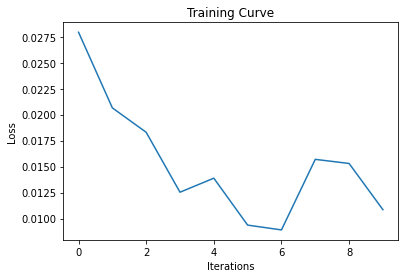

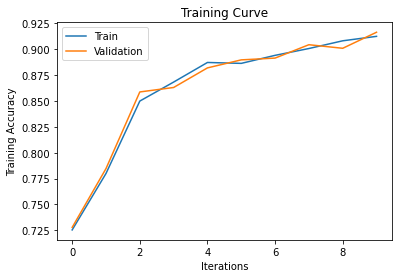

Final Training Accuracy: 0.9124820659971306
Final Validation Accuracy: 0.9164513350559862


In [23]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V2()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 10)

In [26]:
#Test
best_model = CNN_V2()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V2", 32, 0.00012, 9)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

test accuracy: 0.9234737747205503


CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.7216642754662841
Epoch #: 1 Accuracy: 0.7710186513629842
Epoch #: 2 Accuracy: 0.8315638450502152
Epoch #: 3 Accuracy: 0.8573888091822095
Epoch #: 4 Accuracy: 0.8797704447632712
Epoch #: 5 Accuracy: 0.8777618364418939
Epoch #: 6 Accuracy: 0.8869440459110474
Epoch #: 7 Accuracy: 0.8932568149210904
Epoch #: 8 Accuracy: 0.9032998565279771
Epoch #: 9 Accuracy: 0.9044476327116212
Epoch #: 10 Accuracy: 0.9076040172166427
Epoch #: 11 Accuracy: 0.9098995695839311
Epoch #: 12 Accuracy: 0.914490674318508
Epoch #: 13 Accuracy: 0.9133428981348637
Epoch #: 14 Accuracy: 0.9162123385939742
Epoch #: 15 Accuracy: 0.914490674318508
Epoch #: 16 Accuracy: 0.9228120516499283
Epoch #: 17 Accuracy: 0.9173601147776184
Epoch #: 18 Accuracy: 0.9219512195121952
Epoch #: 19 Accuracy: 0.9259684361549498


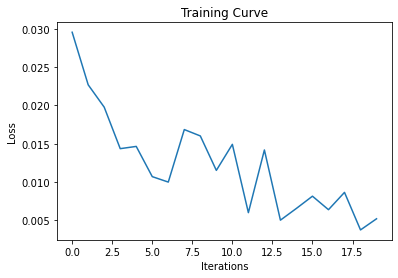

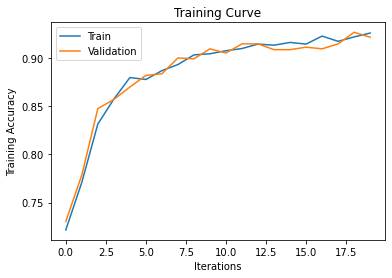

Final Training Accuracy: 0.9259684361549498
Final Validation Accuracy: 0.921619293712317


In [27]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V2()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.0001, num_epochs = 20)

In [28]:
#Test
best_model = CNN_V2()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V2", 32, 0.0001, 18)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.9260533104041273
